**NOTES**

Using this notebook with CASIAv2.0 dataset requires a runtime with at least 4Gb of system RAM and 64GB of disk. With a CPU runtime on Google Colab, it took around 5 minutes (or 0.006 compute units) to run the whole notebook.


In [ ]:
!pip install tensorflow==2.15.0

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
from PIL import Image

IMAGE_SIZE = (384, 256)

def process_image(directory, file):
    try:
        image_filename = directory + '/' + file
        image = Image.open(image_filename, 'r')
        image = image.convert('L')
        image = image.resize(IMAGE_SIZE, Image.LANCZOS)
        data = image.getdata()
        width, height = image.size
        array = np.array(data, dtype=np.uint8).reshape((height, width, 1))
        array = find_gradient(array)
        return array.astype(np.uint8)
    finally:
        image.close()

def find_gradient(image_array):
    H, W, Ch = image_array.shape
    gradient_array = np.zeros((H, W, 8), dtype=np.int16)  # Use int16 for intermediate calculations

    # Define all 8 offsets
    adjacent_offsets = [
        (-1, -1), (-1, 0), (-1, 1),
        ( 0, -1),          ( 0, 1),
        ( 1, -1), ( 1, 0), ( 1, 1)
    ]

    # Calculate the gradient for each offset without padding
    for k, (di, dj) in enumerate(adjacent_offsets):
        shifted_i, shifted_j = slice(1 + di, H - 1 + di), slice(1 + dj, W - 1 + dj)
        center_i, center_j = slice(1, H - 1), slice(1, W - 1)
        # Compute absolute gradient and store in the gradient array
        gradient_array[center_i, center_j, k] = np.abs(image_array[shifted_i, shifted_j, 0].astype(np.int16) - image_array[center_i, center_j, 0].astype(np.int16))

    return gradient_array

In [ ]:
import tensorflow as tf

# Specify the path to the saved model file
binary_classifier_model_path = "/content/gdrive/MyDrive/TFM/binary_classifier_model_for_tampering_detection_based_on_luminance_gradient.keras"

# Load the model
binary_classifier_model = tf.keras.models.load_model(binary_classifier_model_path)

In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

EXPERIMENTATION_SET = []

#directory = Path("/content/gdrive/My Drive/TFM/photos")
#directory = Path("/content/gdrive/My Drive/TFM/twitter")
directory = Path("/content/gdrive/My Drive/TFM/taken")

for path in directory.rglob("*"):
    if path.is_file():
        dir_path = str(path.parent)  # Parent directory of the file
        file_name = str(path.name)   # File name
        if file_name.lower().endswith((".jpg", ".jpeg", ".png")):
            EXPERIMENTATION_SET.append(process_image(dir_path, file_name))

preds = binary_classifier_model.predict(np.array(EXPERIMENTATION_SET))
binary_classes = (preds >= 0.37).astype(int)

print(binary_classes)

1/1 [==============================] - 1s 1s/step
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]]


In [ ]:
from tensorflow.keras.models import load_model

# Specify the path to the saved model file
localizer_model_path = "/content/gdrive/MyDrive/TFM/localizer_model_for_tampering_detection_based_on_luminance.keras"

# Load the model
localizer_model = load_model(localizer_model_path)

Image 1 : /content/gdrive/My Drive/TFM/taken / IMG_20240929_173324.jpg
Image 2 : /content/gdrive/My Drive/TFM/taken / IMG_20241002_192651.jpg
Image 3 : /content/gdrive/My Drive/TFM/taken / IMG_20241009_181508.jpg
Image 4 : /content/gdrive/My Drive/TFM/taken / IMG_20241012_174248.jpg
Image 5 : /content/gdrive/My Drive/TFM/taken / IMG_20241019_095853.jpg
Image 6 : /content/gdrive/My Drive/TFM/taken / IMG_20241019_121942.jpg
Image 7 : /content/gdrive/My Drive/TFM/taken / IMG_20241019_122055.jpg
Image 8 : /content/gdrive/My Drive/TFM/taken / IMG_20241102_150638.jpg
Image 9 : /content/gdrive/My Drive/TFM/taken / IMG_20241210_182503.jpg
Image 10 : /content/gdrive/My Drive/TFM/taken / IMG_20241227_173455.jpg
Image 11 : /content/gdrive/My Drive/TFM/taken / IMG_20241225_214023.jpg
Image 12 : /content/gdrive/My Drive/TFM/taken / IMG_20250101_000750.jpg
1/1 [==============================] - 14s 14s/step


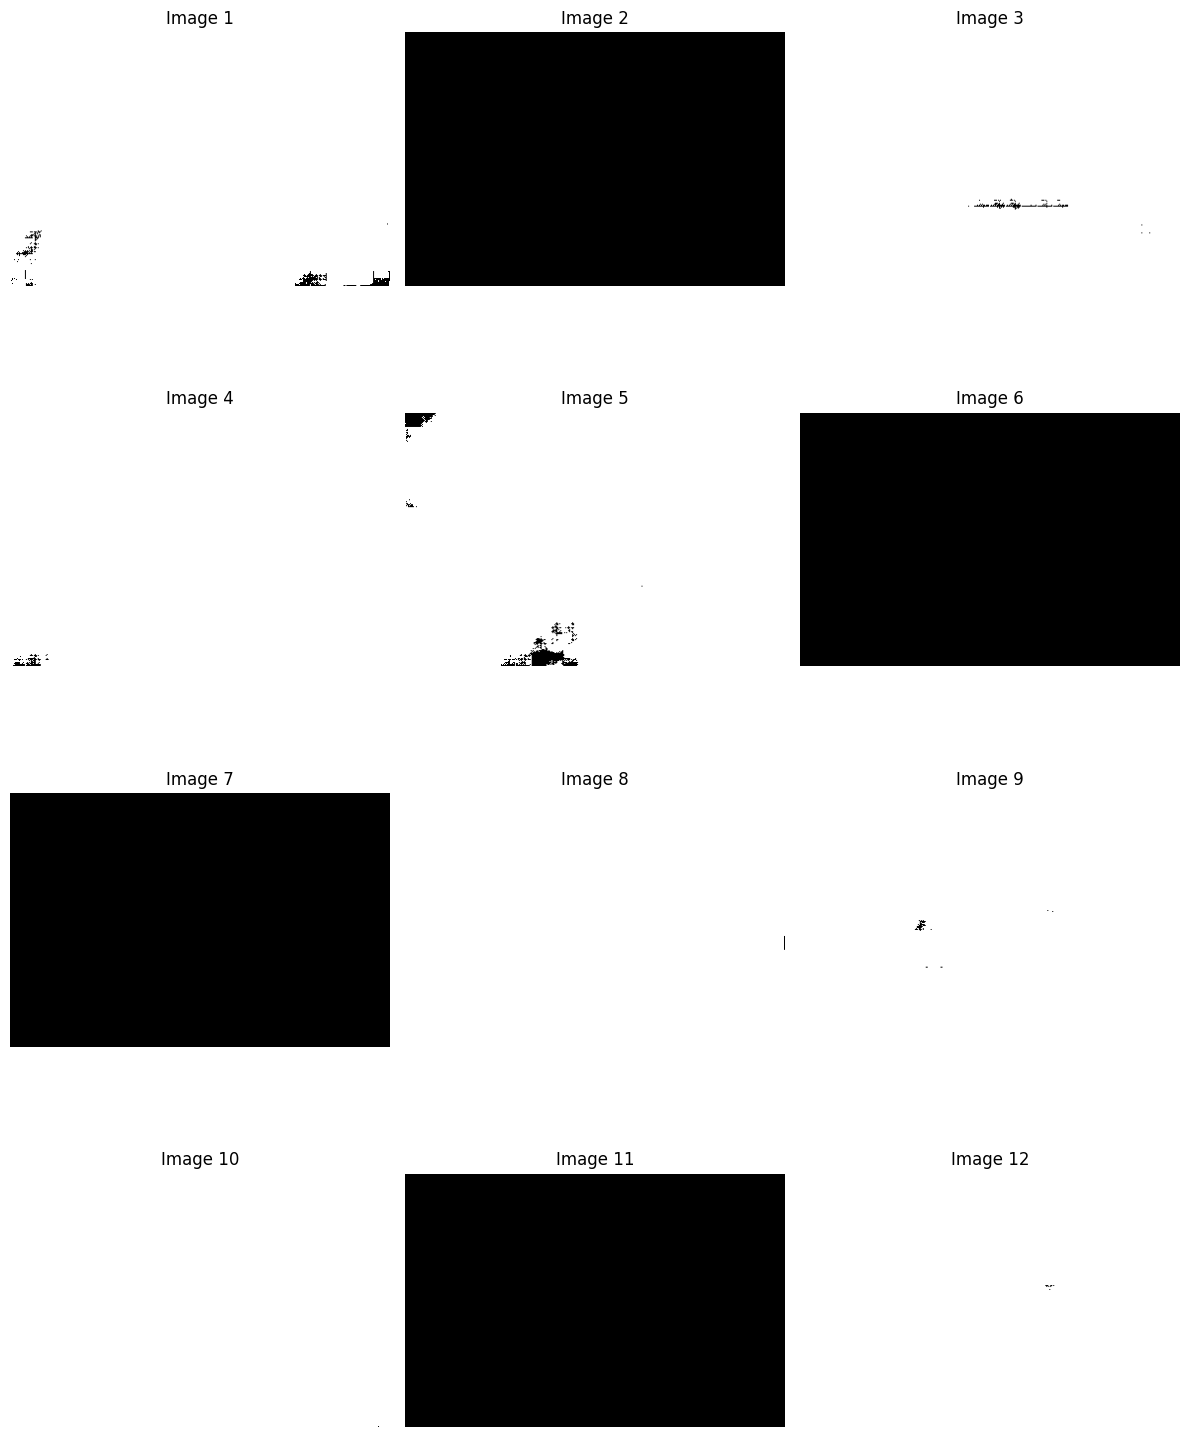

In [ ]:
import math
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

EXPERIMENTATION_SET = []

#directory = Path("/content/gdrive/My Drive/TFM/photos")
#cols = 3

#directory = Path("/content/gdrive/My Drive/TFM/twitter")
#cols = 8

directory = Path("/content/gdrive/My Drive/TFM/taken")
cols = 3

# Assuming process_image(dir_path, file_name) is defined and processes the images
i = 1
for path in directory.rglob("*"):
    if path.is_file():
        dir_path = str(path.parent)  # Parent directory of the file
        file_name = str(path.name)   # File name
        if file_name.lower().endswith((".jpg", ".jpeg", ".png")):
            print("Image", i, ":", dir_path, "/", file_name)
            i = i + 1
            EXPERIMENTATION_SET.append(process_image(dir_path, file_name))

# Predict and classify
preds = localizer_model.predict(np.array(EXPERIMENTATION_SET))
binary_classes = (preds >= 0.25).astype(int)

# Calculate grid dimensions
num_images = len(binary_classes)
rows = math.ceil(num_images / cols)

# Create the grid dynamically
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

# Plot each image in its respective subplot
for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(binary_classes[i], cmap='gray')  # Display the image (grayscale)
        ax.axis('off')  # Turn off axes for better visualization
        ax.set_title(f"Image {i+1}")  # Add a title for each image
    else:
        ax.axis('off')  # Turn off unused subplots

# Adjust spacing between subplots
plt.tight_layout()
plt.show()